<a href="https://colab.research.google.com/github/kushal-h/Deep-Learning-Implementations/blob/master/CNN/Plant_disease_detection_using_resnet50_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

 99% 2.03G/2.04G [00:21<00:00, 109MB/s] 
100% 2.04G/2.04G [00:21<00:00, 103MB/s]


In [ ]:
!unzip /content/plantvillage-dataset.zip

Installing folder split library

In [ ]:
!pip install split-folders

Splitting the data into test and training dataset

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('/content/plantvillage dataset/segmented', output="out", seed=1337, ratio=(0.9, 0.1),
                   group_prefix=None) # default values

Copying files: 54306 files [00:10, 5040.84 files/s]


Import neccessary packages

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Dataset path

In [ ]:
train_data_dir = '/content/out/train'
val_data_dir = '/content/out/val'

Loading Resnet50 model

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


Freezing the base model

In [ ]:
base_model.trainable = False

Defining the custon head to the network

In [ ]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
global_average_layers = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [ ]:
global_average_layers

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
prediction_layers = tf.keras.layers.Dense(units=38, activation='sigmoid')(global_average_layers)

In [ ]:
prediction_layers

<KerasTensor: shape=(None, 38) dtype=float32 (created by layer 'dense')>

Defining the model


In [ ]:
model = tf.keras.models.Model(inputs= base_model.input, outputs= prediction_layers) #combining 2 networks

In [ ]:
base_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Compiling the model

In [ ]:
model.compile(optimizer= 'adam', loss='categorical_crossentropy',
                metrics = ['accuracy'])

Data Generators

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=30,
     width_shift_range=0.3,
     height_shift_range=0.3,
     horizontal_flip=True,
     fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128,128),
    batch_size=128,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
      val_data_dir,
      target_size=(128,128),
      batch_size=128,
      class_mode='categorical')


Found 48858 images belonging to 38 classes.
Found 5448 images belonging to 38 classes.


Traning the model

In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

In [ ]:
history = model.fit(train_generator,epochs=6, validation_data=validation_generator, callbacks = callbacks)

Epoch 1/6
382/382 [==============================] - 2939s 8s/step - loss: 3.3237 - accuracy: 0.1323 - val_loss: 3.2130 - val_accuracy: 0.1222

Epoch 00001: val_loss improved from inf to 3.21298, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 2/6
382/382 [==============================] - 2964s 8s/step - loss: 3.2516 - accuracy: 0.1601 - val_loss: 3.1346 - val_accuracy: 0.1390

Epoch 00002: val_loss improved from 3.21298 to 3.13458, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 3/6
382/382 [==============================] - 2936s 8s/step - loss: 3.2023 - accuracy: 0.1716 - val_loss: 3.0758 - val_accuracy: 0.1641

Epoch 00003: val_loss improved from 3.13458 to 3.07584, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 4/6
382/382 [==============================] - 2962s 8s/step - loss: 3.1640 - accuracy: 0.1769 - val_loss: 3.0261 - val_accuracy: 0.1854

Epoch 00004: val_loss improved from 3.07584 to 3.02605, saving mo

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy


NameError: ignored

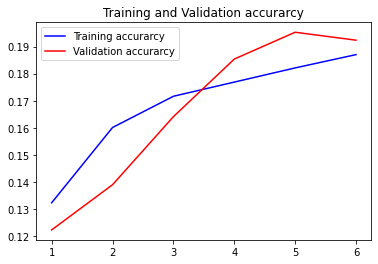

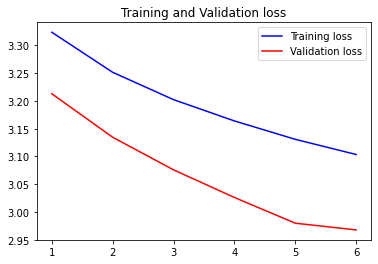

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Retrain After 6 Epoch 

In [ ]:
history = model.fit(train_generator,epochs=10, validation_data=validation_generator, callbacks = callbacks, initial_epoch=6)

Epoch 7/10
382/382 [==============================] - 2913s 8s/step - loss: 3.0767 - accuracy: 0.1921 - val_loss: 2.9050 - val_accuracy: 0.2122

Epoch 00007: val_loss improved from 2.96759 to 2.90499, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 8/10
382/382 [==============================] - 2935s 8s/step - loss: 3.0554 - accuracy: 0.1961 - val_loss: 2.8931 - val_accuracy: 0.2160

Epoch 00008: val_loss improved from 2.90499 to 2.89305, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 9/10
382/382 [==============================] - 2956s 8s/step - loss: 3.0347 - accuracy: 0.2029 - val_loss: 2.8619 - val_accuracy: 0.2105

Epoch 00009: val_loss improved from 2.89305 to 2.86194, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 10/10
382/382 [==============================] - 2999s 8s/step - loss: 3.0137 - accuracy: 0.2069 - val_loss: 2.8269 - val_accuracy: 0.2342

Epoch 00010: val_loss improved from 2.86194 to 2.82687, 

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy


NameError: ignored

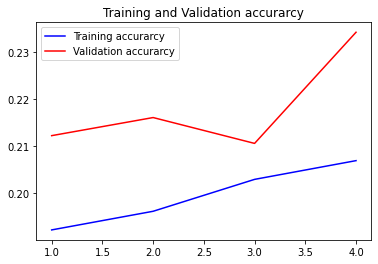

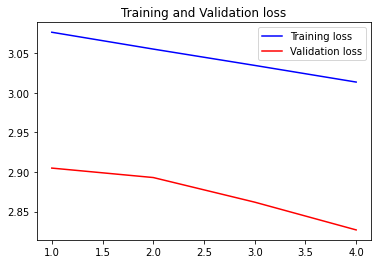

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
 9/43 [=====>........................] - ETA: 3:59 - loss: 2.4605 - accuracy: 0.3472

KeyboardInterrupt: ignored

In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 10 epoch

In [ ]:
history = model.fit(train_generator,epochs=20, validation_data=validation_generator, callbacks = callbacks, initial_epoch=10)

Epoch 11/20
382/382 [==============================] - 2566s 7s/step - loss: 2.9988 - accuracy: 0.2114 - val_loss: 2.8147 - val_accuracy: 0.2333

Epoch 00011: val_loss improved from inf to 2.81466, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 12/20
382/382 [==============================] - 2564s 7s/step - loss: 2.9803 - accuracy: 0.2173 - val_loss: 2.8037 - val_accuracy: 0.2300

Epoch 00012: val_loss improved from 2.81466 to 2.80368, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 13/20
382/382 [==============================] - 2571s 7s/step - loss: 2.9657 - accuracy: 0.2206 - val_loss: 2.7554 - val_accuracy: 0.2454

Epoch 00013: val_loss improved from 2.80368 to 2.75537, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 14/20
382/382 [==============================] - 2562s 7s/step - loss: 2.9519 - accuracy: 0.2240 - val_loss: 2.7295 - val_accuracy: 0.2564

Epoch 00014: val_loss improved from 2.75537 to 2.72949, s

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 244s 6s/step - loss: 2.6351 - accuracy: 0.2812
Test Accuracy: 28.120410442352295


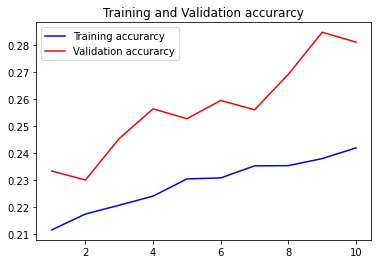

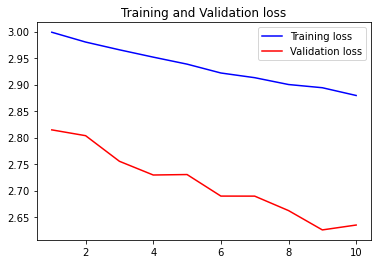

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 290s 7s/step - loss: 2.6259 - accuracy: 0.2849
Test Accuracy: 28.487518429756165


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 20 epoch

In [ ]:
history = model.fit(train_generator,epochs=35, validation_data=validation_generator, callbacks = callbacks, initial_epoch=20)

NameError: ignored

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 295s 7s/step - loss: 2.4859 - accuracy: 0.3254
Test Accuracy: 32.544052600860596


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

NameError: ignored

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 272s 6s/step - loss: 2.4859 - accuracy: 0.3254
Test Accuracy: 32.544052600860596


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 34 epoch

In [ ]:
history = model.fit(train_generator,epochs=40, validation_data=validation_generator, callbacks = callbacks, initial_epoch=34)

Epoch 35/40
382/382 [==============================] - 2858s 7s/step - loss: 2.7696 - accuracy: 0.2674 - val_loss: 2.4931 - val_accuracy: 0.3212

Epoch 00035: val_loss did not improve from 2.47576
Epoch 36/40
382/382 [==============================] - 2859s 7s/step - loss: 2.7685 - accuracy: 0.2686 - val_loss: 2.4694 - val_accuracy: 0.3311

Epoch 00036: val_loss improved from 2.47576 to 2.46943, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 37/40
382/382 [==============================] - 2857s 7s/step - loss: 2.7647 - accuracy: 0.2701 - val_loss: 2.4295 - val_accuracy: 0.3394

Epoch 00037: val_loss improved from 2.46943 to 2.42953, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 38/40
382/382 [==============================] - 2860s 7s/step - loss: 2.7507 - accuracy: 0.2694 - val_loss: 2.4264 - val_accuracy: 0.3454

Epoch 00038: val_loss improved from 2.42953 to 2.42636, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Ep

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 272s 6s/step - loss: 2.4290 - accuracy: 0.3346
Test Accuracy: 33.46182107925415


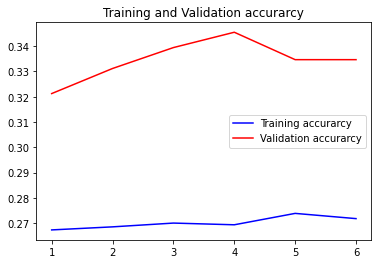

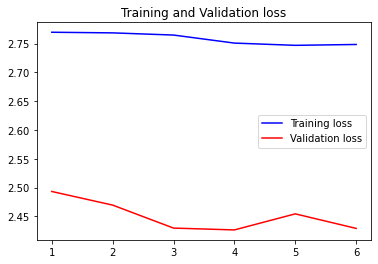

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 276s 6s/step - loss: 2.4264 - accuracy: 0.3454
Test Accuracy: 34.54478681087494


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 40 epoch

In [ ]:
history = model.fit(train_generator,epochs=50, validation_data=validation_generator, callbacks = callbacks, initial_epoch=40)

Epoch 41/50
382/382 [==============================] - 2871s 8s/step - loss: 2.7457 - accuracy: 0.2731 - val_loss: 2.4196 - val_accuracy: 0.3388

Epoch 00041: val_loss improved from inf to 2.41960, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 42/50
382/382 [==============================] - 2861s 7s/step - loss: 2.7481 - accuracy: 0.2709 - val_loss: 2.4285 - val_accuracy: 0.3370

Epoch 00042: val_loss did not improve from 2.41960
Epoch 43/50
382/382 [==============================] - 2865s 8s/step - loss: 2.7390 - accuracy: 0.2729 - val_loss: 2.4195 - val_accuracy: 0.3354

Epoch 00043: val_loss improved from 2.41960 to 2.41947, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 44/50
382/382 [==============================] - 2871s 8s/step - loss: 2.7294 - accuracy: 0.2775 - val_loss: 2.4205 - val_accuracy: 0.3359

Epoch 00044: val_loss did not improve from 2.41947
Epoch 45/50
382/382 [==============================] - 2883s 8s/step - loss:

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 269s 6s/step - loss: 2.3782 - accuracy: 0.3473
Test Accuracy: 34.728339314460754


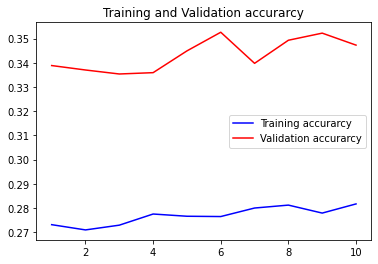

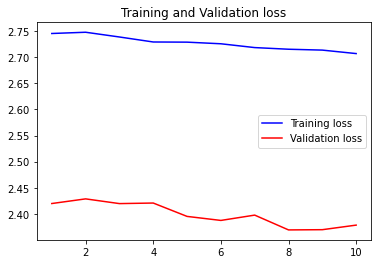

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 273s 6s/step - loss: 2.3690 - accuracy: 0.3493
Test Accuracy: 34.93025004863739


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 50 epoch

In [ ]:
history = model.fit(train_generator,epochs=55, validation_data=validation_generator, callbacks = callbacks, initial_epoch=50)

Epoch 51/55
382/382 [==============================] - 2863s 7s/step - loss: 2.7111 - accuracy: 0.2801 - val_loss: 2.3810 - val_accuracy: 0.3486

Epoch 00051: val_loss improved from inf to 2.38098, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 52/55
382/382 [==============================] - 2856s 7s/step - loss: 2.7123 - accuracy: 0.2802 - val_loss: 2.3704 - val_accuracy: 0.3482

Epoch 00052: val_loss improved from 2.38098 to 2.37042, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 53/55
382/382 [==============================] - 2856s 7s/step - loss: 2.7051 - accuracy: 0.2822 - val_loss: 2.3715 - val_accuracy: 0.3442

Epoch 00053: val_loss did not improve from 2.37042
Epoch 54/55
382/382 [==============================] - 2858s 7s/step - loss: 2.7047 - accuracy: 0.2834 - val_loss: 2.3727 - val_accuracy: 0.3465

Epoch 00054: val_loss did not improve from 2.37042
Epoch 55/55
382/382 [==============================] - 2851s 7s/step - loss:

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 270s 6s/step - loss: 2.3598 - accuracy: 0.3532
Test Accuracy: 35.31571328639984


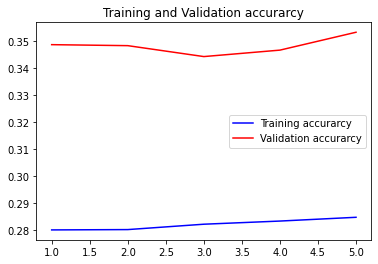

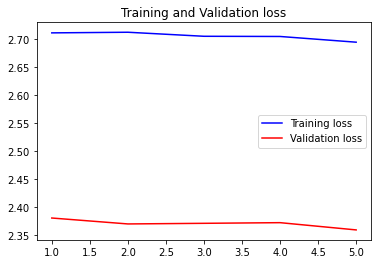

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 276s 6s/step - loss: 2.3598 - accuracy: 0.3532
Test Accuracy: 35.31571328639984


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 55 epoch

In [ ]:
history = model.fit(train_generator,epochs=65, validation_data=validation_generator, callbacks = callbacks, initial_epoch=55)

Epoch 56/65
382/382 [==============================] - 2915s 8s/step - loss: 2.6840 - accuracy: 0.2866 - val_loss: 2.3313 - val_accuracy: 0.3554

Epoch 00056: val_loss improved from inf to 2.33135, saving model to /content/drive/MyDrive/AgriDoc/model_resnet50.h5
Epoch 57/65
382/382 [==============================] - 2927s 8s/step - loss: 2.6846 - accuracy: 0.2866 - val_loss: 2.3523 - val_accuracy: 0.3561

Epoch 00057: val_loss did not improve from 2.33135
Epoch 58/65
382/382 [==============================] - 2914s 8s/step - loss: 2.6808 - accuracy: 0.2881 - val_loss: 2.3455 - val_accuracy: 0.3554

Epoch 00058: val_loss did not improve from 2.33135
Epoch 59/65
382/382 [==============================] - 2920s 8s/step - loss: 2.6755 - accuracy: 0.2881 - val_loss: 2.3448 - val_accuracy: 0.3585

Epoch 00059: val_loss did not improve from 2.33135
Epoch 60/65
382/382 [==============================] - 2924s 8s/step - loss: 2.6726 - accuracy: 0.2888 - val_loss: 2.3162 - val_accuracy: 0.3642



In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 276s 6s/step - loss: 2.3007 - accuracy: 0.3620
Test Accuracy: 36.196768283843994
[INFO] Calculating model accuracy
43/43 [==============================] - 276s 6s/step - loss: 2.3007 - accuracy: 0.3620
Test Accuracy: 36.196768283843994


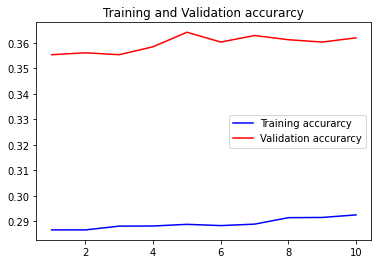

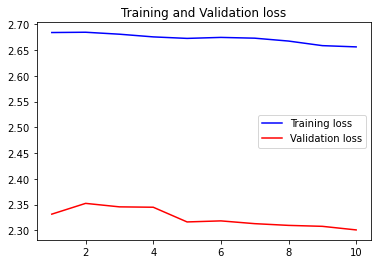

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Loading the Model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/AgriDoc/model_resnet50.h5")

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 276s 6s/step - loss: 2.2540 - accuracy: 0.3695
Test Accuracy: 36.949339509010315


In [ ]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/AgriDoc/model_resnet50.h5', 
                                                     monitor = 'val_loss',
                                                      verbose = 1, 
                                                      save_best_only= True)

In [ ]:
callbacks = [model_check_point]  

##Retrain After 65 epoch

In [ ]:
history = model.fit(train_generator,epochs=80, validation_data=validation_generator, callbacks = callbacks, initial_epoch=65)

NameError: ignored

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
43/43 [==============================] - 275s 6s/step - loss: 2.2540 - accuracy: 0.3695
Test Accuracy: 36.949339509010315


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

NameError: ignored